### Filtrando i dati

devo leggere tutt .csv e salvare solamente la 'close' di ogni csv

In [23]:
import cudf as cf
from bollinger_filter import backtest_bollinger_strategy

eurgbp = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurgbp-m1-bid-2015-01-01-2025-01-30T14:40.csv')
train_size = 0.1
eurgbp_train = eurgbp.iloc[:int(len(eurgbp)*train_size)] #selects the first slice of data as training set
eurgbp_test = eurgbp.iloc[int(len(eurgbp)*train_size):] #$selects the second slice of data as test set


#audnzd = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/audnzd-m1-bid-2015-01-01-2025-01-31T15:24.csv')
#eurchf = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurchf-m1-bid-2024-01-01-2025-01-28.csv')

### Alternative data from ForexHistData.com

In [1]:
#HERE I TEST WITH ALTERNATIVE DATA FROM FOREXSHISTDATA.COM

from bollinger_filter import backtest_bollinger_strategy
import cudf as cf
test = cf.read_parquet('/home/edoardocame/Desktop/python_dir/data/eurgbp_merged.parquet')
test.sort_index(inplace=True)
test.reset_index(inplace=True)
test.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
test.tail()

,timestamp,open,high,low,close,volume
6598968,2025-01-31 16:54:00,0.83602,0.83604,0.83584,0.83585,0
6598969,2025-01-31 16:55:00,0.83582,0.83598,0.83577,0.83591,0
6598970,2025-01-31 16:56:00,0.83590,0.83593,0.83579,0.83588,0
6598971,2025-01-31 16:57:00,0.83587,0.83589,0.83577,0.83581,0
6598972,2025-01-31 16:58:00,0.83578,0.83578,0.83558,0.83566,0


### Ottimizzazione dei parametri con pandas/polars
Devo ottimizzare i parametri dei backtest per poi testarli nel portafoglio combinato

In [ ]:
#Questa è la via pandas, susseguentemente farò quella con polars;
#ci mettono lo stesso identico tempo in termini di velocità.

import pandas as pd
import time as t

my_combinations = pd.read_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations.csv', index_col=0)

start_time = t.time()

####################
my_combinations['result'] = 0
def apply_strategy(row):
    result = backtest_bollinger_strategy(data=eurgbp, lookback=row['lookback'], 
                                         sdev=row['sdev'], leverage=10, filter=row['filter'], fee_percentage=0.01)
    print(f"Processed lookback: {row['lookback']}, sdev: {row['sdev']}, result: {result}, filter: {row['filter']}")
    return result

my_combinations['result'] = my_combinations.apply(apply_strategy, axis=1)
####################

end_time = t.time() - start_time

print(f"Time elapsed: {end_time}")

In [3]:
my_combinations.to_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations_results.csv')

### Analisi dei migliori parametri
Qui analizzo quali sono i migliori parametri trovati per EUR/GBP;
Poi farò lo stesso con le altre coppie.

In [ ]:
import cudf as cf

my_combinations = cf.read_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations_results.csv', index_col=0)
params = my_combinations[my_combinations['result'] == my_combinations['result'].max()]
print(params)

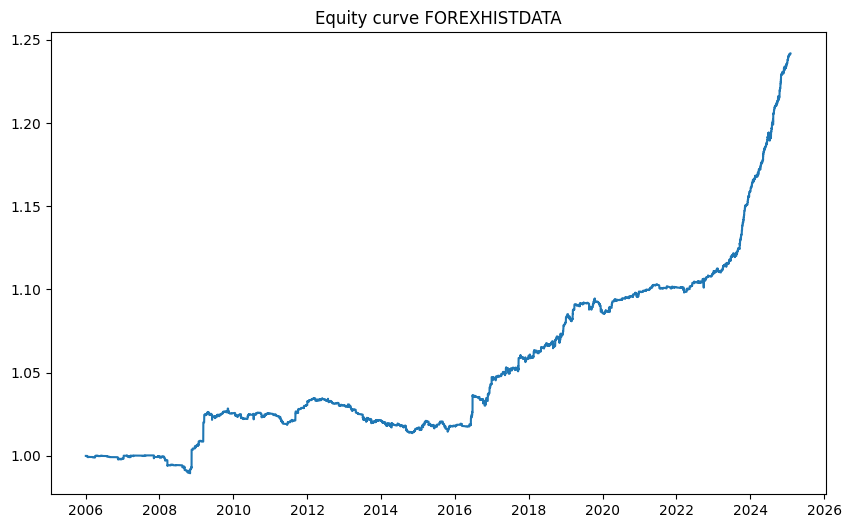

In [18]:
from bollinger_filter import backtest_bollinger_strategy
import cudf as cf

esempio = backtest_bollinger_strategy(data = test, lookback= 60, sdev= 5, 
                                      fee_percentage=0.005, return_series=True, leverage=1, filter=0)

#print(esempio)
import matplotlib.pyplot as plt
esempio.index = test['timestamp']
esempio.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(esempio)
plt.title('Equity curve FOREXHISTDATA')
plt.show()

Qui voglio vedere se i filtri hanno avuto effetto;

In [ ]:
import cudf as cf

df = cf.read_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations_results.csv')
df = df.dropna()

#Voglio vedere se la media dei risultati varia significativamente in base al filtro;
#Se non varia, posso escluderlo dalla strategia.
df.groupby('filter')['result'].mean()

#### Plot 3d dei risultati
Esempio di ottimizzazione con eur/gbp: mostriamo un grafico 3d dei risultati;

In [ ]:
import pandas as pd
import plotly.graph_objects as go

my_combinations = pd.read_csv('/home/edoardocame/Desktop/python_dir/transition to cuDF/my_combinations_results_leverage.csv')

#Subset the data keeping only sdevs between 4 and 10
my_combinations = my_combinations[(my_combinations['sdev'] > 3) & (my_combinations['sdev'] < 10)]


z = my_combinations['result'].values
x = my_combinations['sdev'].values
y = my_combinations['lookback'].values

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=12, color=z, colorscale='Viridis', opacity=0.8))])
fig.update_layout(scene = dict(xaxis_title='Standard Deviation', yaxis_title='Lookback', zaxis_title='Result'))
fig.show()